In [1]:
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import tensorflow as tf
# from tensorflow import keras

In [4]:
random_seed = 42
# tf.random.set_seed(random_seed)
import numpy as np
np.random.seed(random_seed)

In [5]:
import pandas as pd

train_url = 'https://raw.githubusercontent.com/Nayaeun/23Spring_ML_Final/main/train.csv'
df_raw_train = pd.read_csv(train_url)
df_train = df_raw_train.copy(deep=True)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

In [7]:
df_train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [8]:
df_train.isnull().sum().sum() # sum of null values in the dataset

0

In [9]:
# Display dataset's summary statistics
print(df_train.describe())

                Id     Elevation        Aspect         Slope  \
count  15120.00000  15120.000000  15120.000000  15120.000000   
mean    7560.50000   2749.322553    156.676653     16.501587   
std     4364.91237    417.678187    110.085801      8.453927   
min        1.00000   1863.000000      0.000000      0.000000   
25%     3780.75000   2376.000000     65.000000     10.000000   
50%     7560.50000   2752.000000    126.000000     15.000000   
75%    11340.25000   3104.000000    261.000000     22.000000   
max    15120.00000   3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000         

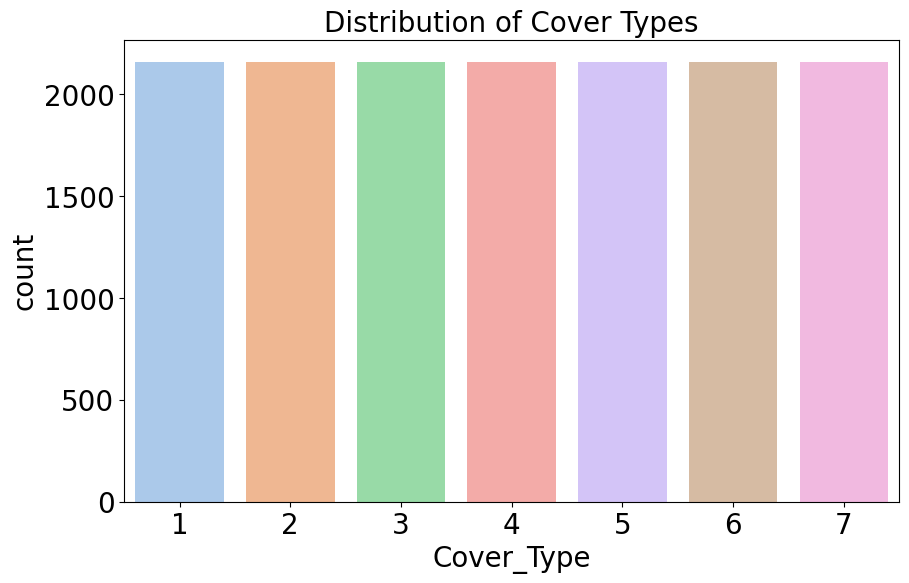

In [10]:
# Visualize the distribution of cover types
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='Cover_Type', palette='pastel')
plt.title('Distribution of Cover Types')
plt.show()


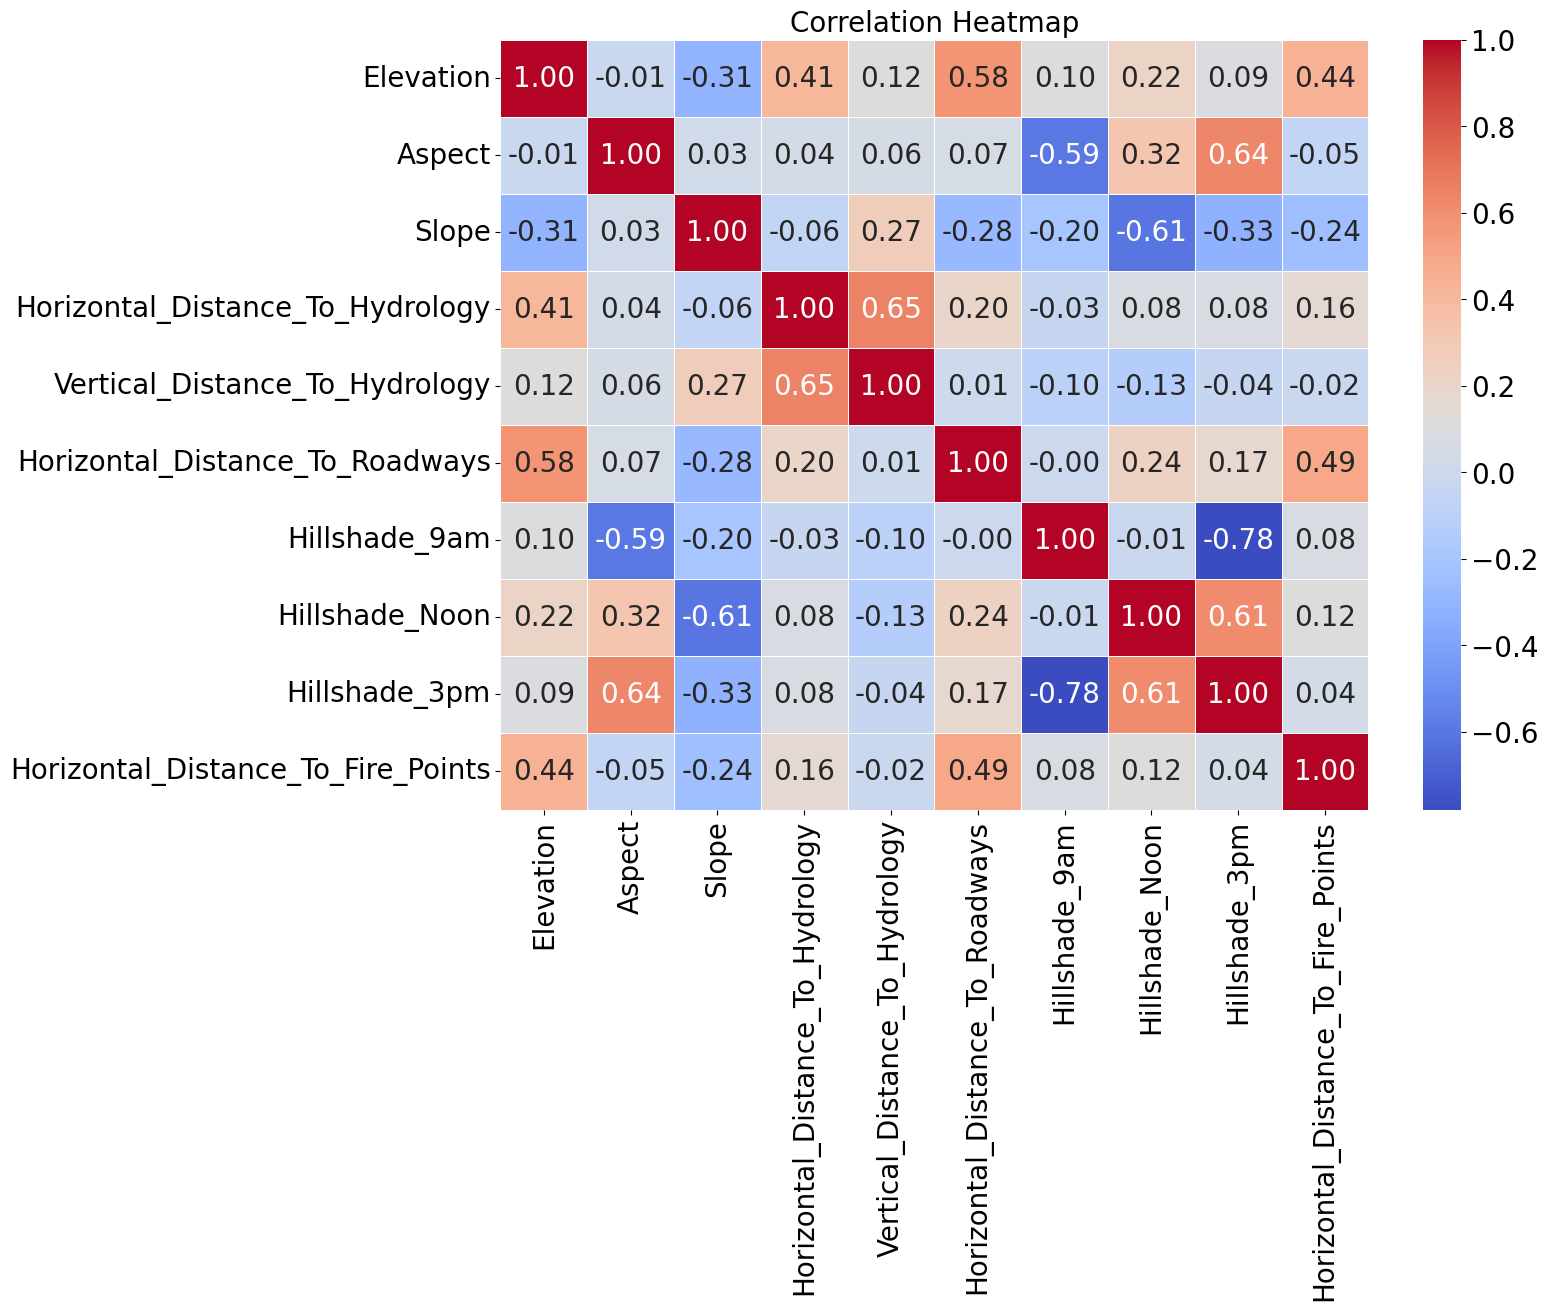

In [11]:
cols = []
for i in df_train.columns:
    if ('soil' in i.lower()) or ('wilderness' in i.lower()) or ('type' in i.lower()) or ('id' in i.lower()):
        continue
    else:
        cols.append(i)
# Compute the correlation matrix
corr_matrix = df_train[cols].corr()
    
# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


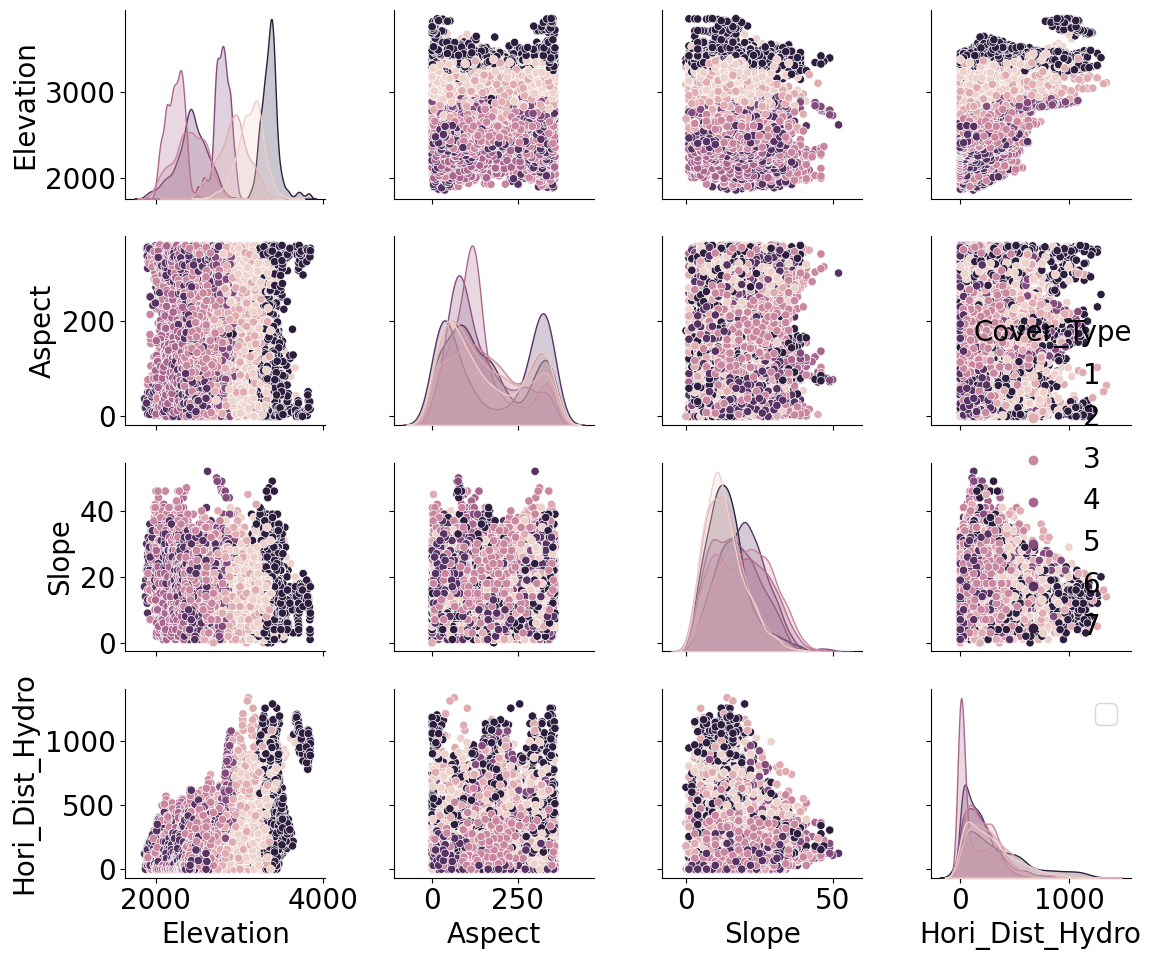

In [27]:
# Visualize relationships between selected features using a pairplot
subset_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Cover_Type']
df_subset = df_train[subset_features]
df_subset.columns = ['Elevation', 'Aspect', 'Slope', 'Hori_Dist_Hydro', 'Cover_Type']
sns.pairplot(df_subset, hue='Cover_Type')
plt.tight_layout()
plt.legend()
plt.show()

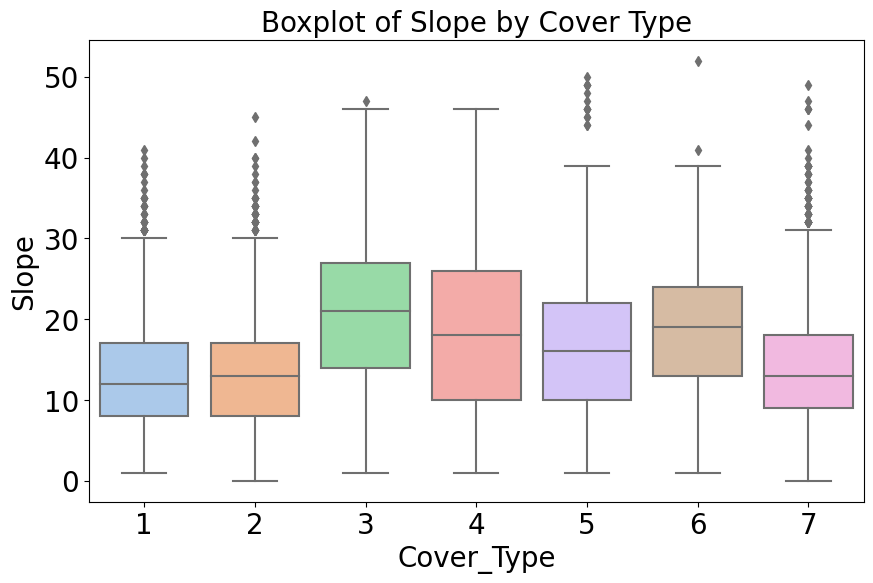

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x='Cover_Type', y='Slope', palette='pastel')
plt.title('Boxplot of Slope by Cover Type')
plt.show()

def remove_outliers(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers for the 'Slope' feature
cleaned_data = remove_outliers(df_train, 'Slope')

In [17]:
df_train.shape, cleaned_data.shape

((15120, 56), (15063, 56))

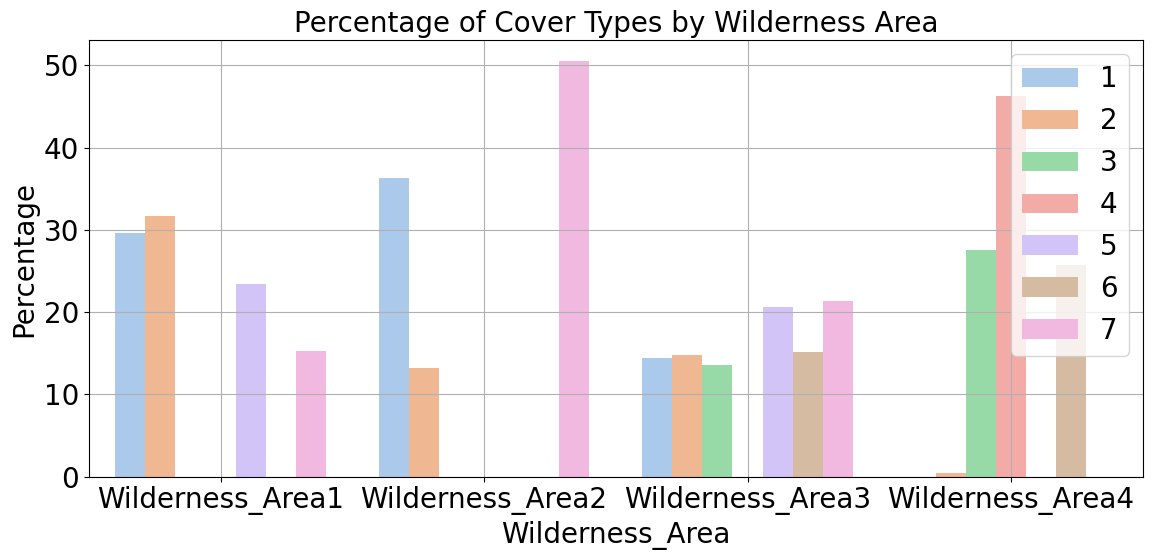

In [35]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'cleaned_data' is your DataFrame with outliers removed

wilderness_cols = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']
wilderness_data = cleaned_data.melt(id_vars='Cover_Type', value_vars=wilderness_cols, var_name='Wilderness_Area', value_name='Present')

# Filter the data to include only the rows where the wilderness area is present
wilderness_data = wilderness_data[wilderness_data['Present'] == 1]

# Calculate the total count of each wilderness area
wilderness_counts = wilderness_data['Wilderness_Area'].value_counts()

# Calculate the percentage with respect to the total count of each wilderness area
wilderness_data['Percentage'] = wilderness_data.apply(lambda row: 100 * (1 / wilderness_counts[row['Wilderness_Area']]), axis=1)

plt.figure(figsize=(12, 6))
sns.barplot(data=wilderness_data, x='Wilderness_Area', y='Percentage', hue='Cover_Type', estimator=sum, palette='pastel', ci=None)
plt.ylabel('Percentage')
plt.grid()
plt.title('Percentage of Cover Types by Wilderness Area')
plt.legend()
plt.tight_layout()
plt.show()


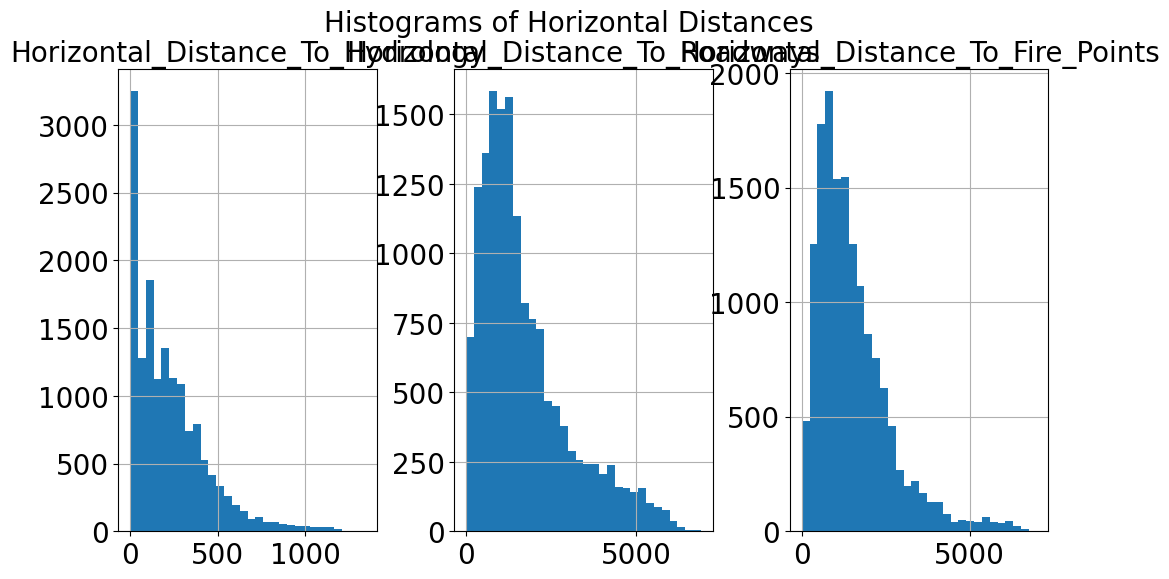

In [19]:
distance_cols = ['Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
df_train[distance_cols].hist(bins=30, figsize=(12, 6), layout=(1, 3))
plt.suptitle('Histograms of Horizontal Distances')
plt.show()


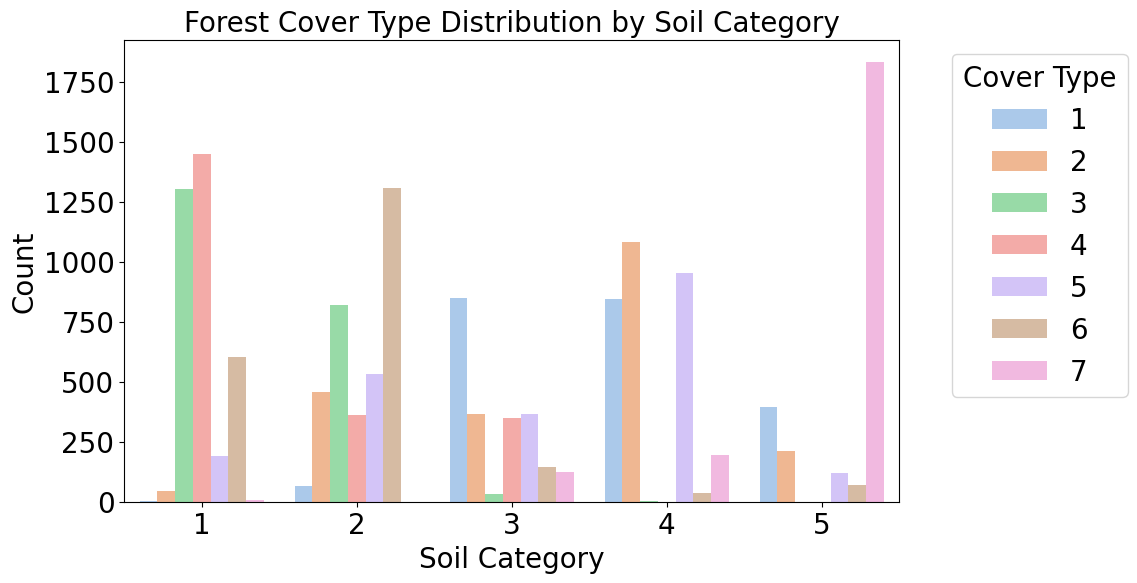

In [23]:
# Assuming the new soil categories are defined as follows:
# Category 1: Soil_Type1 - Soil_Type8
# Category 2: Soil_Type9 - Soil_Type16
# Category 3: Soil_Type17 - Soil_Type24
# Category 4: Soil_Type25 - Soil_Type32
# Category 5: Soil_Type33 - Soil_Type40

def get_soil_category(row):
    for i in range(1, 6):
        if row[f'Soil_Type{(i-1)*8+1}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+2}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+3}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+4}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+5}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+6}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+7}'] == 1:
            return i
        if row[f'Soil_Type{(i-1)*8+8}'] == 1:
            return i
    return np.nan
# Create a new column for the aggregated soil categories
df_train['Soil_Category'] = df_train.apply(get_soil_category, axis=1)

# Create a new column for the aggregated soil categories
soil_category_cover_type = df_train.groupby(['Soil_Category', 'Cover_Type']).size().unstack().reset_index()

# Melt the data frame to have a long format suitable for seaborn barplot
melted_data = soil_category_cover_type.melt(id_vars='Soil_Category', var_name='Cover_Type', value_name='Count')

# Create seaborn barplot with 'pastel' palette
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_data, x='Soil_Category', y='Count', hue='Cover_Type', palette='pastel')

plt.xlabel('Soil Category')
plt.ylabel('Count')
plt.title('Forest Cover Type Distribution by Soil Category')
plt.legend(title='Cover Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [24]:
##Training data

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

In [25]:
# Split the data into features (X) and target (y)
X = cleaned_data.drop(columns=["Id", "Cover_Type"])
y = cleaned_data["Cover_Type"]

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the pipeline steps
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
]

# Create the pipeline
pipeline = Pipeline(pipeline_steps)

# Define the model and hyperparameter options for GridSearchCV
models = [
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [None, 10, 20]
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3, 5, 7]
    },
    {
        'model': [MLPClassifier()],
        'model__hidden_layer_sizes': [(50,), (100,)],
        'model__activation': ['relu', 'tanh'],
        'model__solver': ['adam'],
        'model__max_iter': [200]
    },
    {
        'model': [DecisionTreeClassifier()],
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10]
    }
]

# Create GridSearchCV with the pipeline and model options
grid_search = GridSearchCV(pipeline, models, cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best model and its score
print(f"Best model: {grid_search.best_estimator_}")
print(f"Best F1 macro score: {grid_search.best_score_}")

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Test F1 macro score: {test_f1_macro}")

Fitting 5 folds for each of 37 candidates, totalling 185 fits
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])
Best F1 macro score: 0.8505885375892918
Test F1 macro score: 0.8565342004698275


In [26]:
from sklearn.metrics import classification_report

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Generate and print the prettified classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

           1       0.75      0.78      0.76       425
           2       0.79      0.64      0.71       439
           3       0.84      0.84      0.84       418
           4       0.94      0.98      0.96       435
           5       0.86      0.94      0.90       378
           6       0.86      0.87      0.87       468
           7       0.95      0.96      0.96       450

    accuracy                           0.86      3013
   macro avg       0.86      0.86      0.86      3013
weighted avg       0.86      0.86      0.86      3013

